In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal, rv_discrete

In this notebook we provide stand-alone implementations of our primary proposed procedures:

| *Method*            | *Marginal coverage guarantee?* | *Tunable parameter?* | *Comments* |
| :---------------- | :------:| :------:|----: |
| **Standard CP with PAS**        |   Yes   | No | Targets macro-coverage, lightweight procedure |
| **Raw Fuzzy CP**           |   No   | Yes | |
| **Fuzzy CP**     |  Yes   | Yes |Requires holdout set for reconformalization |
| **Interp-Q** |  No  | Yes |Lightweight procedure |


### First, let's generate some synthetic data

We'll generate labels $Y \in \mathcal{Y}$ where $|\mathcal{Y}|=100$ and the class distribution is long-tailed. To get softmax vectors, we fit a logistic regression model to features $X$ sampled from a multivariate Gaussian distribution conditional on $Y$.

Val accuracy: 0.723
CPU times: user 5min 25s, sys: 11min 18s, total: 16min 43s
Wall time: 13.1 s


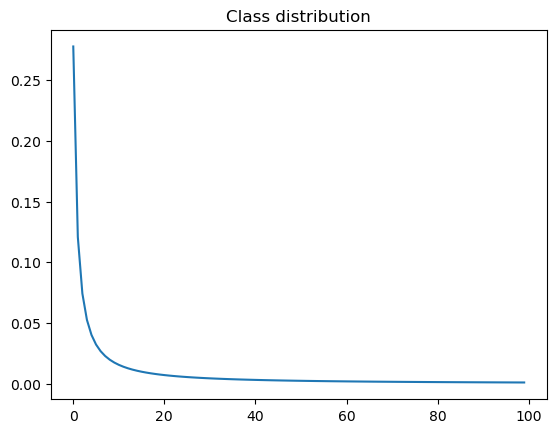

In [2]:
%%time
np.random.seed(0)

# 1) Define a long-tailed Pareto class prior for 100 classes
def zipf_prior(num_classes=100, zipf_param=1.2):
    ranks = np.arange(1, num_classes + 1)
    prior_raw = ranks ** (-zipf_param)
    prior = prior_raw / prior_raw.sum()

    return prior

# 2) Sample X, Y datasets
def sample_dataset(n, prior, feature_dim=20, class_sep=1, seed=None):
    rng = np.random.default_rng(seed)
    num_classes = len(prior)
    # Create class means
    means = rng.standard_normal((num_classes, feature_dim)) * class_sep
    # Sample labels according to prior
    ys = rng.choice(num_classes, size=n, p=prior)
    # Sample features around class means
    X = np.vstack([
        rng.multivariate_normal(means[y], np.eye(feature_dim))
        for y in ys
    ])
    return X, ys

# 3) Train logistic regression
def train_classifier(X_train, y_train):
    clf = LogisticRegression(solver='lbfgs', max_iter=500)
    clf.fit(X_train, y_train)
    return clf


# Dataset sizes
n_train, n_val, n_test = 20000, 5000, 50000
n_total = n_train + n_val + n_test
feature_dim = 10

# Class prior
prior = zipf_prior()
plt.plot(prior)
plt.title('Class distribution')

# Sample dataset
X, y = sample_dataset(n_total, prior, feature_dim)

# Split intro train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        train_size=n_train,
        stratify=y
    )
test_frac = n_test / (n_val + n_test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    train_size=n_val,
    stratify=y_temp
)

# Train classifier
clf = train_classifier(X_train, y_train)

# Get softmax scores on val and test
val_softmax  = clf.predict_proba(X_val)
test_softmax = clf.predict_proba(X_test)

train_labels = y_train
val_labels = y_val
test_labels = y_test

num_classes = val_softmax.shape[1]

print(f'Val accuracy: {np.mean(np.argmax(val_softmax, axis=1) == val_labels):.3f}')

## Baselines

We now implement some baselines to compare against.

**Baseline A:** We consider Standard CP with the commonly used $\mathsf{softmax}$ score function, defined as
$$s_{\mathsf{softmax}}(x,y) = 1 - \hat{p}(y|x)$$
where $\hat{p}(y|x)$ is the $y$-th entry of the softmax vector given features $x$.

**Baseline B:** We consider Classwise CP (also with the $\mathsf{softmax}$ score function)

In [3]:
alpha = 0.1 # Desired miscoverage level

def compute_conformal_quantile(scores, alpha):
    '''
    Inputs: 
        - scores: (num_samples,)
        - alpha: scalar in [0,1]
    '''
    n = len(scores)
    val = np.ceil((n+1)*(1-alpha))/n
    if val > 1:
        qhat = np.inf
    else:
        qhat = np.quantile(scores, val, method='inverted_cdf')
    return qhat
    

def compute_qhat(scores_all, labels, alpha):
    '''
    Inputs:
        - scores_all: (num_samples, num_classes)
        - labels: (num_samples,)
        - alpha: scalar in [0,1]
    '''
    # Select scores of true label
    scores = [scores_all[i, labels[i]] for i in range(len(labels))]

    return compute_conformal_quantile(scores, alpha)

def standard_CP(val_scores_all, val_labels, test_scores_all, alpha):
    '''
    Inputs:
        - val_scores_all: (n, num_classes)
        - val_labels: (n, )
        - test_scores_all: (m, num_classes)
        - alpha: scalar in [0,1]
    '''

    # Get qhat
    qhat = compute_qhat(val_scores_all, val_labels, alpha)

    # Create prediction sets
    pred_sets = []
    for i in range(len(test_scores_all)):
        pred_sets.append(np.where(test_scores_all[i,:] <= qhat)[0])

    return pred_sets

def create_classwise_prediction_sets(scores_all, q_hats):
    '''
    Inputs:
        - scores_all: num_instances x num_classes array where scores_all[i,j] = score of class j for instance i
        - q_hats: as output by compute_class_specific_quantiles
    '''
    set_preds = []
    for i in range(len(scores_all)):
        set_preds.append(np.where(scores_all[i,:] <= q_hats)[0])

    return set_preds

def classwise_CP(val_scores_all, val_labels, test_scores_all, alpha):
    '''
    Inputs:
        - val_scores_all: (n, num_classes)
        - val_labels: (n, )
        - test_scores_all: (m, num_classes)
        - alpha: scalar in [0,1]
    '''
    num_classes = val_scores_all.shape[1]
    q_hats = np.zeros((num_classes,)) # q_hats[i] = qhat for class i

    for k in range(num_classes):
        idx = (val_labels == k) # Only select examples for which k is true class
        q_hats[k] = compute_qhat(val_scores_all[idx], val_labels[idx], alpha)

    return create_classwise_prediction_sets(test_scores_all, q_hats)
            

def compute_softmax_scores(softmax):
    return 1 - softmax

val_softmax_scores = compute_softmax_scores(val_softmax)
test_softmax_scores = compute_softmax_scores(test_softmax)

standard_pred_sets = standard_CP(val_softmax_scores, val_labels, test_softmax_scores, alpha)

classwise_pred_sets = classwise_CP(val_softmax_scores, val_labels, test_softmax_scores, alpha)

## Method 1: Standard Conformal Prediction with the PAS score function

*Background:* PAS stands for "prevalence-adjusted softmax." This score function is designed to approximate the oracle sets that optimally trade off set size and _macro-coverage_, which is defined as

$$\mathrm{MacroCov} = \frac{1}{|\mathcal{Y}|} \sum_{y \in \mathcal{Y}} P(Y \in C(X) \mid Y = y).$$

The PAS score function is computed as

$$s_{\mathsf{PAS}}(x,y) = -\frac{\hat p (y|x)}{\hat p(y)},$$

where $\hat p (y|x)$ is an estimate of the conditional probability of label $y$ given $X=x$ and $\hat p(y)$ is an estimate of the class distribution. We will use the softmax vector as our $\hat p (y|x)$ and the class distribution in the model training set as our $\hat p(y)$.

In [4]:
def estimate_class_distribution(labels):
    num_classes = np.max(labels) + 1
    class_distr = np.array([np.sum(labels == k) for k in range(num_classes)]) / len(labels)
    return class_distr

def compute_PAS_scores(softmax_scores, class_distribution):
    '''
    Inputs:
        - softmax_scores: (n, num_classes)
        - class_distribution: (num_classes,)
    '''
    return - softmax_scores / class_distribution


class_distribution = estimate_class_distribution(train_labels)
val_PAS = compute_PAS_scores(val_softmax, class_distribution)
test_PAS = compute_PAS_scores(test_softmax, class_distribution)

std_PAS_pred_sets = standard_CP(val_PAS, val_labels, test_PAS, alpha)

## Methods 2a and 2b: Raw Fuzzy and (reconformalized) Fuzzy CP

*Background:* Fuzzy classwise conformal prediction (Fuzzy CP for short) smoothly interpolates between Standard CP and Classwise CP as you vary the bandwidth of the weight kernel. The key idea is that Standard and Classwise CP can be viewed as special cases of label-weighted CP, where in Standard CP the weights are uniform across all classes, and in Classwise CP the weights are 1 only for calibration points of the same class and 0 otherwise. Fuzzy CP interpolates between these two extremes by defining weights based on a kernel centered at class $y$. Proximity is measured in a low-dimensional space to which classes are mapped. 

**Tunable parameter:** Decrease `bandwidth` to get better class-conditional coverage (at the expense of larger sets)

In [5]:
def fuzzy_CP(val_scores_all, val_labels, test_scores_all, alpha, 
              class_mapping, bandwidth=0.01, reconformalize_data=None, seed=0):
    '''
    Inputs:
        - val_scores_all: (n, num_classes)
        - val_labels: (n, )
        - test_scores_all: (m, num_classes)
        - alpha: scalar in [0,1]
        - class_mapping: function from class index to a scalar
        - bandwidth: a positive scalar
        - reconformalize_data: (holdout_scores_all, holdout_labels) where 
                holdout_scores_all is (num_holdout, num_classes)
                holdout_labels is (num_holdout,)
    '''
 
    np.random.seed(0) # for reproducibility if using a projection with randomness

    n, num_classes = val_scores_all.shape
    val_scores = [val_scores_all[i, val_labels[i]] for i in range(n)] # Select scores of true label

    proj_arr = [class_mapping(y) for y in range(num_classes)]

    class_qhats = np.zeros((num_classes,))

    F = {} # used for reconformalization. F[k] is the k-weighted score distribution
    for k in range(num_classes):
        n_k = np.sum(val_labels == k)
        sd = bandwidth/(n_k+1) # + 1 to account for classes with 0 examples
        cls_weights = multivariate_normal.pdf(proj_arr, mean=proj_arr[k], cov=sd)

        # Map each calibration example to a weight depending on its class
        weights = [cls_weights[y] for y in val_labels]

        # Add weight for test y (essentially the weighted CP version of the 1/(n+1) adjustment)
        weights += [cls_weights[k]]
        weights = np.array(weights)
        
        # Compute weighted quantile (note that due to numerical imprecision,
        # it is better to let np.quantile do the normalization of weights within the function)
        S_all = np.concatenate((val_scores, [np.inf]))
        weighted_quantile = np.quantile(S_all, q=1 - alpha, weights=weights, method="inverted_cdf")
        
        class_qhats[k] = weighted_quantile

        # Store k-weighted score distribution
        def deduplicate(arr, weights):
            unique_arr, inverse = np.unique(arr, return_inverse=True)
            agg_weights = np.zeros_like(unique_arr, dtype=weights.dtype)
            np.add.at(agg_weights, inverse, weights)
        
            return unique_arr, agg_weights

        weights = weights / np.sum(weights)
        unique_S, agg_weights = deduplicate(S_all, weights)
        F[k] = rv_discrete(values=(unique_S, agg_weights)) 

    num_inf_qhats = np.sum(np.isinf(class_qhats))
    if num_inf_qhats > 0:
        print(f'FUZZY CP WARNING: {num_inf_qhats} classes have qhat=infinity (and will always be included in the prediction set)' )

    # 3) [Optional] Re-conformalize the qhats to ensure marginal coverage
    if reconformalize_data is not None: 
        # Find the alpha' such that taking the 1-alpha' quantile of the class-weighted score distribution
        # yields 1-alpha marginal coverage
        # This implies the score function s(x,y) = What quantile of the w(y)-weighted score distribution should I have
        # taken to include y in the prediction set? 
        
        holdout_scores_all, holdout_labels = reconformalize_data
        reconf_scores = [holdout_scores_all[i, holdout_labels[i]] for i in range(len(holdout_labels))]
        reconf_labels = holdout_labels

        S = np.array([F[y].cdf(reconf_scores[i]) for i,y in enumerate(reconf_labels)]) 
        alpha_hat = 1 - compute_conformal_quantile(S, alpha) 
        class_qhats = np.array([F[y].ppf(1-alpha_hat) for y in range(num_classes)])
  
    # 4) Construct prediction sets 
    pred_sets = create_classwise_prediction_sets(test_scores_all, class_qhats)

    return pred_sets

def raw_fuzzy_CP(val_scores_all, val_labels, test_scores_all, alpha, 
                 class_mapping, bandwidth=0.01, seed=0):

    return fuzzy_CP(val_scores_all, val_labels, test_scores_all, alpha, 
              class_mapping, bandwidth=bandwidth, seed=seed)

def reconformalized_fuzzy_CP(val_scores_all, val_labels, test_scores_all, alpha, 
                 class_mapping, bandwidth=0.01, num_holdout=1000, seed=0):

    # Hold out data for reconformalization
    print(f'Holding out {num_holdout} of {len(val_labels)} examples for reconformalization step')
    shuffle_idx = np.random.permutation(np.arange(len(val_labels)))
    holdout_idx = shuffle_idx[:num_holdout]
    cal_idx = shuffle_idx[num_holdout:]
    
    cal_scores_all, cal_labels = val_scores_all[cal_idx], val_labels[cal_idx]
    holdout_scores_all, holdout_labels = val_scores_all[holdout_idx], val_labels[holdout_idx]

    return fuzzy_CP(cal_scores_all, cal_labels, test_scores_all, alpha, 
                    class_mapping, bandwidth=bandwidth, 
                    reconformalize_data=(holdout_scores_all, holdout_labels),
                    seed=seed)
    

# Define class mapping!
# We use the prevalence class mapping, which maps each class to its (normalized) 
# prevalence in the training set (+ noise to ensure uniqueness w.p. 1)
cts = np.array([np.sum(train_labels == k) for k in range(num_classes)])
norm_cts = cts/np.max(cts) # Normalize to [0,1]
norm_cts = norm_cts + np.random.uniform(low=-.01, high=.01, size=cts.shape)
prevalence_mapping = lambda y: norm_cts[y]    
                
bandwidth = 0.01 # This should be tuned to your setting. Larger values prioritize set size over class-conditional coverage

raw_fuzzy_pred_sets = raw_fuzzy_CP(val_softmax_scores, val_labels, test_softmax_scores, alpha, 
                                   prevalence_mapping, bandwidth=0.01, seed=0)

fuzzy_pred_sets = reconformalized_fuzzy_CP(val_softmax_scores, val_labels, test_softmax_scores, alpha, 
                                   prevalence_mapping, bandwidth=0.01, seed=0)    

Holding out 1000 of 5000 examples for reconformalization step


## Method 3: Interp-Q

*Background:* This method interpolates between Standard CP and Classwise CP in a literal sense; it linearly interpolates between the $\hat q$ from Standard CP and $\hat q_y^{\mathrm{CW}}$ from Classwise CP (after replacing infinite values of $\hat q_y^{\mathrm{CW}}$ with 1)

**Tunable parameter:** Increase `classwise_weight` to get better class-conditional coverage (at the expense of larger sets)

In [6]:
def interpQ(val_scores_all, val_labels, test_scores_all, alpha, classwise_weight):
    '''
    Inputs:
        - val_scores_all: (n, num_classes)
        - val_labels: (n, )
        - test_scores_all: (m, num_classes)
        - alpha: scalar in [0,1]
        - classwise_weight: (scalar in [0,1]) weight on Classwise qhat when computing weighted average
                qhat_y = classwise_weight * (Classwise qhat_y) + (1 - classwise_weight) * (Standard qhat)
    '''
    num_classes = val_scores_all.shape[1]

    # Get Standard CP qhat
    std_qhat = compute_qhat(val_scores_all, val_labels, alpha)
    
    # Get Classwise CP qhats
    cw_qhats = np.zeros((num_classes,)) # q_hats[i] = qhat for class i
    for k in range(num_classes):
        idx = (val_labels == k) # Only select examples for which k is true class
        cw_qhats[k] = compute_qhat(val_scores_all[idx], val_labels[idx], alpha)
    cw_qhats[np.isinf(cw_qhats)] = 1

    # Take weighted average 
    qhats = classwise_weight * cw_qhats + (1-classwise_weight) * std_qhat

    # Construct prediction sets 
    pred_sets = create_classwise_prediction_sets(test_scores_all, qhats)

    return pred_sets

classwise_weight = 0.5 # This should be tuned to your setting. Smaller values prioritize set size over class-conditional coverage
interpQ_pred_sets = interpQ(val_softmax_scores, val_labels, test_softmax_scores, alpha, 
                            classwise_weight)      

### Aggregate results

In [7]:
results = {'Standard': standard_pred_sets,
           'Classwise': classwise_pred_sets,
           'Standard w. PAS': std_PAS_pred_sets,
           'Raw Fuzzy': raw_fuzzy_pred_sets,
           'Fuzzy': fuzzy_pred_sets,
           'Interp-Q': interpQ_pred_sets}

## Evaluate

We consider the following metrics:
1. Marginal coverage
2. Class-conditional coverage
3. Macro coverage = (unweighted) average class-conditional coverage
4. Average set size

In [8]:
## Functions for computing evaluation metrics

def compute_marginal_coverage(pred_sets, labels):
    num_correct = 0
    for true_label, preds in zip(labels, pred_sets):
        if true_label in preds:
            num_correct += 1
    set_pred_acc = num_correct / len(labels)
    
    return set_pred_acc

def compute_class_conditional_coverage(pred_sets, labels):
    num_classes = np.max(labels) + 1
    class_cond_cov = np.zeros((num_classes,))
    for k in range(num_classes):
        idx = np.where(labels == k)[0]
        selected_preds = [pred_sets[i] for i in idx]
        num_correct = np.sum([1 if np.any(pred_set == k) else 0 for pred_set in selected_preds])
        class_cond_cov[k] = num_correct / len(selected_preds)
        
    return class_cond_cov

def compute_avg_set_size(pred_sets):
    return np.mean([len(arr) for arr in pred_sets])

In [9]:
def compute_all_metrics(results, labels):
    """
    Compute marginal coverage, class‐conditional coverages, macro coverage,
    and average set size for each method in `results`.
    
    Returns a DataFrame with columns:
      - method
      - marginal_cov
      - macro_cov
      - avg_set_size
      - class_cond_cov  (array of per‐class coverages)
    """
    rows = []
    for method, pred_sets in results.items():
        # 1) marginal coverage
        marg_cov = compute_marginal_coverage(pred_sets, labels)
        
        # 2) class-conditional coverage vector
        class_cov = compute_class_conditional_coverage(pred_sets, labels)
        
        # 3) macro coverage = mean class-conditional coverage
        macro_cov = np.mean(class_cov)
        
        # 4) average set size
        avg_size = compute_avg_set_size(pred_sets)
        
        rows.append({
            'method':         method,
            'marginal_cov':   marg_cov,
            'class_cond_cov': class_cov,  
            'min_class_cond_cov': np.min(class_cov), 
            'macro_cov':      macro_cov,
            'avg_set_size':   avg_size
        })
    
    return pd.DataFrame(rows)

df_metrics = compute_all_metrics(results, test_labels)

display(df_metrics[['method', 'marginal_cov', 'min_class_cond_cov', 'macro_cov', 'avg_set_size']])

,method,marginal_cov,min_class_cond_cov,macro_cov,avg_set_size
0,Standard,0.90668,0.000000,0.696285,2.64530
1,Classwise,0.91052,0.700000,0.940303,32.89514
2,Standard w. PAS,0.90080,0.576271,0.900635,5.76148
3,Raw Fuzzy,0.90060,0.169492,0.863530,4.81296
4,Fuzzy,0.89422,0.135593,0.844536,4.41702
5,Interp-Q,0.89914,0.033898,0.761234,2.99752


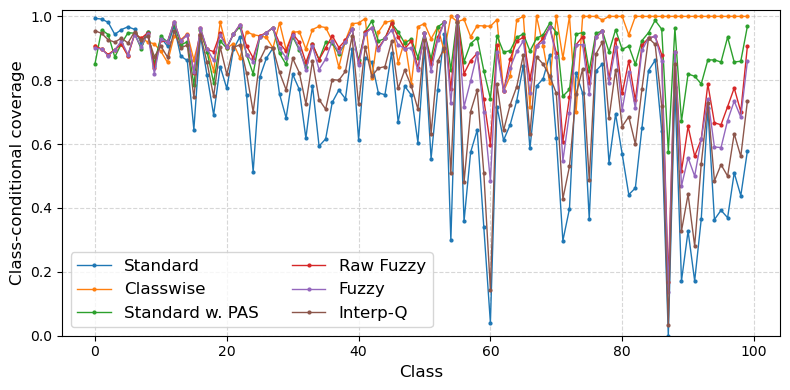

In [10]:
# Plot class-conditional coverage of each method

plt.figure(figsize=(8, 4))
for _, row in df_metrics.iterrows():
    method = row['method']
    class_cov = row['class_cond_cov']
    plt.plot(np.arange(num_classes), class_cov, marker='o', linewidth=1, markersize=2, label=method)

plt.xlabel('Class', fontsize=12)
plt.ylabel('Class‐conditional coverage', fontsize=12)
plt.ylim(0, 1.02)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12, loc='lower left', ncol=2)
plt.tight_layout()
plt.show()